Cleaned Columns: Index(['SYMBOL', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE',
       'TOTTRDQTY', 'TOTTRDVAL', 'TIMESTAMP', 'TOTALTRADES', 'ISIN'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training RNN model...
Epoch 1/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 234s 11ms/step - loss: 2.7858e-04 - val_loss: 1.9247e-04
Epoch 2/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 264s 11ms/step - loss: 2.9334e-04 - val_loss: 1.9269e-04
Epoch 3/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 232s 11ms/step - loss: 3.0599e-04 - val_loss: 1.9028e-04
Epoch 4/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 255s 12ms/step - loss: 2.8778e-04 - val_loss: 1.8942e-04
Epoch 5/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 255s 12ms/step - loss: 2.8035e-04 - val_loss: 1.9086e-04
Epoch 6/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 242s 11ms/step - loss: 2.8740e-04 - val_loss: 1.9094e-04
Epoch 7/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 261s 11ms/step - loss: 2.7566e-04 - val_loss: 1.9133e-04
Epoch 8/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 283s 12ms/step - loss: 2.9315e-04 - val_loss: 1.9318e-04
Epoch 9/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 242s 11ms/step - loss: 2.8540e-04 - val_loss: 1.9470e-04
Epoch 10/20
21159/21159 ━━━━━━━━━━━━━━━━━━━━ 255s 12ms/step - loss: 

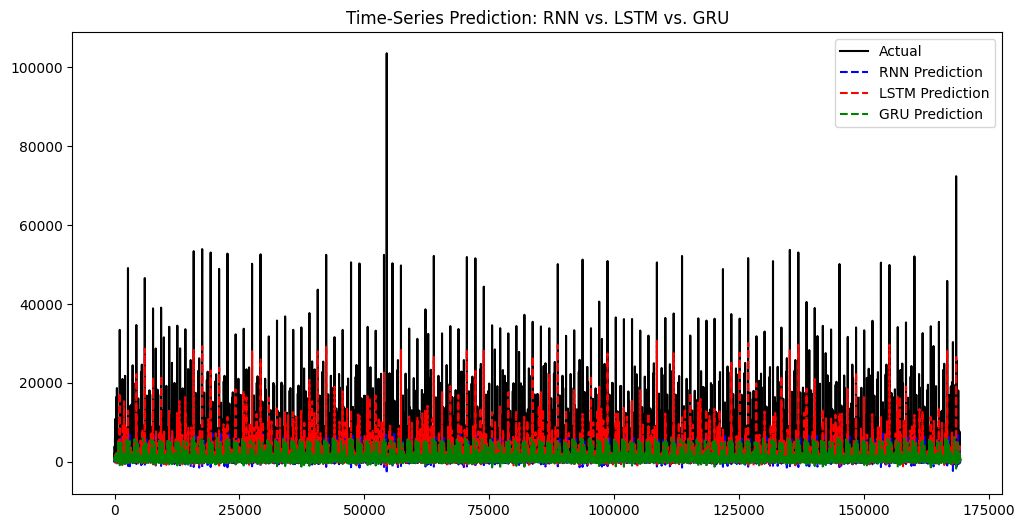

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Define file path
file_path = "/content/FINAL_FROM_DF.csv"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File '{file_path}' not found. Please check the path.")

# Load dataset
df = pd.read_csv(file_path)

# Convert all column names to uppercase for consistency
df.columns = df.columns.str.upper()

# Display column names for debugging
print("Cleaned Columns:", df.columns)

# Ensure 'CLOSE' column exists
if 'CLOSE' not in df.columns:
    raise KeyError(f"Column 'CLOSE' not found in the dataset. Available columns: {df.columns}")

# Use only the 'CLOSE' column for prediction
df = df[['CLOSE']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create input-output pairs using a sliding window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set sequence length
seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Function to create and train a model
def build_and_train_model(model_type):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=False, input_shape=(seq_length, 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    print(f"\nTraining {model_type} model...")
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    return model

# Train models
rnn_model = build_and_train_model("RNN")
lstm_model = build_and_train_model("LSTM")
gru_model = build_and_train_model("GRU")

# Make predictions
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Inverse transform to original scale
rnn_pred = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
gru_pred = scaler.inverse_transform(gru_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual", color="black")
plt.plot(rnn_pred, label="RNN Prediction", linestyle="dashed", color="blue")
plt.plot(lstm_pred, label="LSTM Prediction", linestyle="dashed", color="red")
plt.plot(gru_pred, label="GRU Prediction", linestyle="dashed", color="green")
plt.legend()
plt.title("Time-Series Prediction: RNN vs. LSTM vs. GRU")
plt.show()
